For the last coding assignment, you'll need to implement a neural network. We'll look at a relatively simple binary classification problem. Here below are three options; completing one of them for the exam is enough

### Tasks:

1. Remember: scale your data appropriately

2. Decide on a testing strategy (a simple test/train split? a CV strategy? set a test set aside to be looked at at the very end?)

2. Decide your optimization metric.

3. Write down your network architecture. You can start from a fully connected, multi-layer perceptron (and then explore)

4. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

5. Optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

6. Report on the perfomance of the network on the test set; report other metrics that have not been optimized.


### A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

### Datasets:

You can choose one of these three problems:

- **1. Galaxies vs quasars (but with neural networks)** Go back to our SDSS data we've used in Lecture 19. We had color differences, and the task was to classifty quasars vs galaxies. Repeat that task with a neural network.

- **2. Can a computer learn if we're going to detect gravitational waves? (but with neural networks)** Go back to the SNR classifier for gravitational wave events, same data we've used in Lecture. We had properties of black hole binaries, and the task was to classify. Repeat that task with a neural network.

- **3. The HiggsML challenge** Branching out of astrophysics, let's mess around with a dataset of simulated but  realistic events from the ATLAS particle detector at CERN.
    - Data are at `solutions/higgs.tar.gz` (you need to uncompress with `tar -czvf`)
    - There are $N_{\rm samples} = 2.5\times 10^5$ entries with $N_{\rm features}=30$ features each. 
    - The taks is that of classifying these features against a set of labels, which are either `s` (source) or `b` (background).
    - For some info on both the physics and the dataset see [this document](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf); includes a description of the features and how data have been padded (-999) for missing values.
    - This dataset was part of a challenge that run on Kaggle in 2014: https://higgsml.ijclab.in2p3.fr/ 



#### (On dataset 2, this is the best I could do...)

Together with Alberto Vecchio and Geraint Prattent, I tackled this gravitational-wave classification problem using neural networks in this paper: [arXiv:2007.06585](https://arxiv.org/abs/2007.06585). 
- In the paper we reached an accuracy (true positive + true negative / total) of $98.4\%$. The data you're using are those of the green curve in Fig 2 of that paper. Could you do better? If yes, please tell me how! 
- I should have really put a figure with my ROC in that paper but I didn't!

## classifty quasars vs galaxies with MLP

In [4]:
import setuptools.dist
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
df = pd.read_csv('galaxyquasar.csv')

In [6]:
ug = np.array(df['u']-df['g'])
gr = np.array(df['g']-df['r'])
ri = np.array(df['r']-df['i'])
iz = np.array(df['i']-df['z'])

labels = np.where(df['class'] == 'QSO', 1, 0)

In [15]:
ug

array([0.43537, 1.76946, 1.73268, ..., 1.31842, 1.27429, 1.05021],
      shape=(50000,))

In [22]:
# Stack your features
X = np.column_stack((ug, gr, ri, iz))

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(X)

# First, split into train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    features_scaled, labels, test_size=0.3, random_state=42
)

# Now split the temp set into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15, random_state=42
)
# (0.15 of the remaining 70% ≈ 10.5% of the total data is validation)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Validation set: {X_val.shape}") #only at the end


Train set: (29750, 4)
Test set: (15000, 4)
Validation set: (5250, 4)


In [17]:
# MODEL DEFINITION
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

def create_feature_based_mlp(input_shape, num_classes):
    """
    Create MLP optimized for QSO classification
    """
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # First layer - capture feature interactions
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        # Second layer - refine representations
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        # Third layer - final feature extraction
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create and compile model
input_shape = (X_train.shape[1],)
num_classes = len(np.unique(y_train))
model_mlp = create_feature_based_mlp(input_shape, num_classes )

model_mlp.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(model_mlp.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,354 (173.26 KB)

 Trainable params: 43,458 (169.76 KB)

 Non-trainable params: 896 (3.50 KB)

None


In [19]:
# TRAINING
print("\n=== STARTING TRAINING ===")
history = model_mlp.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test), 
    verbose=1
)


=== STARTING TRAINING ===
Epoch 1/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step - accuracy: 0.9596 - loss: 0.3711 - val_accuracy: 0.9849 - val_loss: 0.2353
Epoch 2/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step - accuracy: 0.9790 - loss: 0.2093 - val_accuracy: 0.9841 - val_loss: 0.1631
Epoch 3/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - accuracy: 0.9807 - loss: 0.1431 - val_accuracy: 0.9845 - val_loss: 0.1209
Epoch 4/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - accuracy: 0.9823 - loss: 0.1121 - val_accuracy: 0.9831 - val_loss: 0.0998
Epoch 5/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.9816 - loss: 0.1002 - val_accuracy: 0.9841 - val_loss: 0.0887
Epoch 6/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - accuracy: 0.9828 - loss: 0.0905 - val_accuracy: 0.9843 - val_loss: 0.0880
Epoch 7/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.9822 - loss: 0.0884 - val_accuracy: 0.9843 - val_loss: 0.0984
Epoch 8/50
930/930 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accurac


=== FINAL TEST SET EVALUATION ===
Validation Accuracy: 0.9857
Validatin Loss: 0.0806


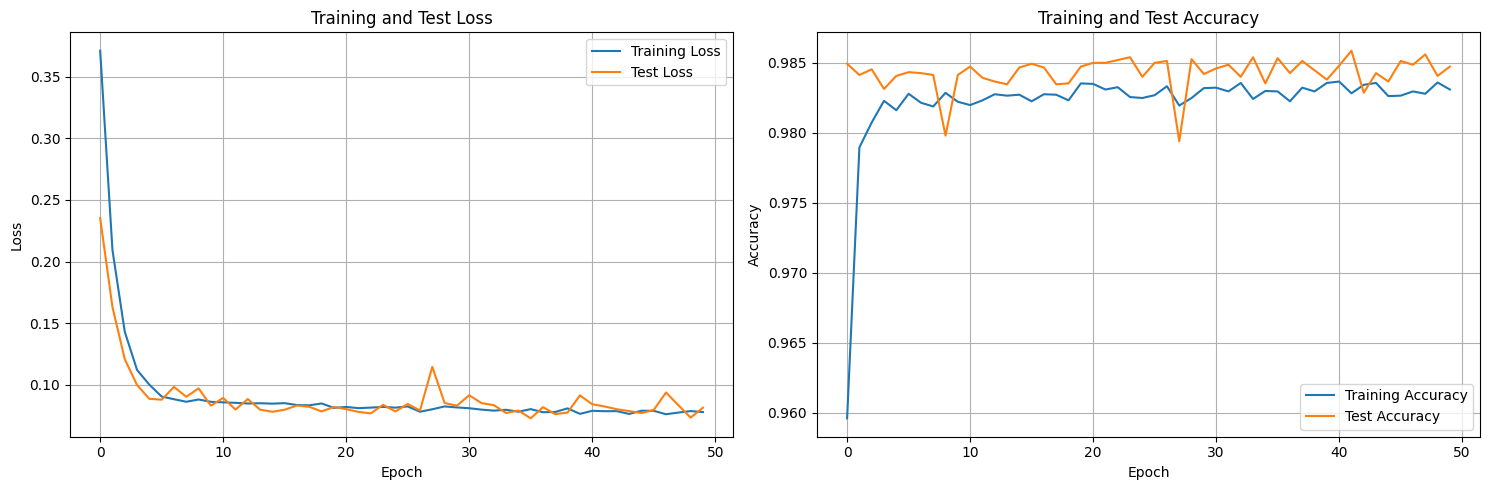

In [20]:
# FINAL EVALUATION
print("\n=== FINAL TEST SET EVALUATION ===")
val_loss, val_accuracy = model_mlp.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validatin Loss: {val_loss:.4f}")

# VISUALIZATION
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Test Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training and Test Accuracy')

plt.tight_layout()
plt.show()